In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.manifold import TSNE
import pandas as pd
import itertools

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image

In [2]:
# USER CONFIG
# -------------------------
DATA_DIR = "Dataset"                # path to parent folder containing Angry/Happy/Sad folders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 80                         # recommended 60-80 for good convergence; adjust as needed
SEED = 42
MODEL_FILENAME = "emotion_mobilenetv2.h5"
AUTOTUNE = tf.data.AUTOTUNE
# -------------------------
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# Utility: gather image paths + labels
# -------------------------
def gather_image_paths(data_dir):
    classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    paths = []
    labels = []
    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        exts = ("*.jpg","*.jpeg","*.png","*.bmp")
        cls_files = []
        for e in exts:
            cls_files.extend(glob(os.path.join(cls_dir, e)))
        # force only RGB images and 224x224 will be ensured by loader; still include everything
        for f in cls_files:
            paths.append(f)
            labels.append(cls)
    return np.array(paths), np.array(labels), classes

paths, labels, class_names = gather_image_paths(DATA_DIR)
print("Found classes:", class_names)
print("Total images:", len(paths))
assert len(paths) > 0, "No images found — check DATA_DIR"


Found classes: ['Angry', 'Happy', 'Sad']
Total images: 7305


In [4]:
# First split train 70% vs temp 30%
paths_train, paths_temp, labels_train, labels_temp = train_test_split(
    paths, labels, test_size=0.30, stratify=labels, random_state=SEED)

# Then split temp into test (20% of total) and val (10% of total).
# temp_size is 0.30; we want test = 0.20 of total => test fraction of temp = 0.20/0.30 = 2/3
test_frac_of_temp = 2/3
paths_test, paths_val, labels_test, labels_val = train_test_split(
    paths_temp, labels_temp, test_size=(1 - test_frac_of_temp), stratify=labels_temp, random_state=SEED)

# Confirm sizes
n_total = len(paths)
print(f"Train: {len(paths_train)} ({len(paths_train)/n_total:.2%})")
print(f"Test:  {len(paths_test)} ({len(paths_test)/n_total:.2%})")
print(f"Val:   {len(paths_val)} ({len(paths_val)/n_total:.2%})")

# -------------------------
# Label binarizer (one-hot)
# -------------------------
lb = LabelBinarizer()
lb.fit(class_names)  # ensure consistent ordering
def labels_to_onehot(labels_array):
    return lb.transform(labels_array)


Train: 5113 (69.99%)
Test:  1461 (20.00%)
Val:   731 (10.01%)


In [5]:
# Create tf.data pipelines
# -------------------------
def preprocess_image(path, label):
    """
    loads image file, decodes, resizes to IMG_SIZE, ensures RGB, scales to [0,1]
    """
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)  # scales to [0,1]
    img = tf.image.resize(img, IMG_SIZE)
    return img, label

In [6]:
# Data augmentation function (applied to training set)
def augment(img, label):
    # tf.image augmentations
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.12)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    # random rotation via tensorflow
    angle = tf.random.uniform([], -0.08, 0.08)
    img = tfa.image.rotate(img, angles=angle) if 'tfa' in globals() else img  # optional, tfa if installed
    return img, label

In [7]:
# Convert numpy arrays of paths & labels into tf.data.Dataset
def make_dataset(paths_np, labels_np, batch_size=BATCH_SIZE, shuffle=True, augment_data=False):
    labels_onehot = labels_to_onehot(labels_np)
    ds = tf.data.Dataset.from_tensor_slices((paths_np.astype(str), labels_onehot.astype(np.float32)))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths_np), seed=SEED)
    ds = ds.map(lambda p, l: preprocess_image(p, l), num_parallel_calls=AUTOTUNE)
    if augment_data:
        try:
            import tensorflow_addons as tfa  # augmentation rotation
            globals()['tfa'] = tfa
        except Exception:
            # tfa optional; rotation skipped if not available
            pass
        ds = ds.map(lambda img, lbl: augment(img, lbl), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(paths_train, labels_train, batch_size=BATCH_SIZE, shuffle=True, augment_data=True)
val_ds   = make_dataset(paths_val, labels_val, batch_size=BATCH_SIZE, shuffle=False, augment_data=False)
test_ds  = make_dataset(paths_test, labels_test, batch_size=BATCH_SIZE, shuffle=False, augment_data=False)


In [8]:
# Compute class weights to handle imbalance
# -------------------------
from sklearn.utils.class_weight import compute_class_weight
unique_labels = np.unique(labels_train)
class_weights_raw = compute_class_weight('balanced', classes=unique_labels, y=labels_train)
class_weight = {i: float(class_weights_raw[i]) for i in range(len(unique_labels))}
print("Class weights (index->weight):", class_weight)


Class weights (index->weight): {0: 0.9783773440489858, 1: 0.9789393069117366, 2: 1.0456032719836401}


In [9]:
# Build MobileNetV2-based model
# -------------------------
num_classes = len(class_names)

def build_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=num_classes):
    base = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base.trainable = True
    # optionally fine-tune only last blocks:
    # for layer in base.layers[:-40]:
    #     layer.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = inputs
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x*255.0)  # since our images are 0-1, scale back
    x = base(x, training=False)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,715 (9.87 MB)

 Trainable params: 2,553,091 (9.74 MB)

 Non-trainable params: 34,624 (135.25 KB)

In [10]:
# Compile
# -------------------------
opt = tf.keras.optimizers.Adam(learning_rate=2e-4)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])  # Keras AUC is micro for multiclass - we'll compute sklearn AUC later

# -------------------------
# Callbacks
# -------------------------
checkpoint = callbacks.ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-7, verbose=1)
earlystop = callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1)  # optional
csv_logger = callbacks.CSVLogger("training_log.csv")

# If you absolutely don't want early stopping, comment earlystop out from callback list.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[checkpoint, reduce_lr, earlystop, csv_logger]
)

Epoch 1/80
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5047 - auc: 0.6945 - loss: 1.3134
Epoch 1: val_accuracy improved from None to 0.41176, saving model to best_model.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.5746 - auc: 0.7745 - loss: 1.1028 - val_accuracy: 0.4118 - val_auc: 0.6185 - val_loss: 3.1975 - learning_rate: 2.0000e-04
Epoch 2/80
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6716 - auc: 0.8750 - loss: 0.7109
Epoch 2: val_accuracy improved from 0.41176 to 0.62791, saving model to best_model.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.6814 - auc: 0.8830 - loss: 0.6827 - val_accuracy: 0.6279 - val_auc: 0.8035 - val_loss: 1.5727 - learning_rate: 2.0000e-04
Epoch 3/80
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7505 - auc: 0.9215 - loss: 0.5259
Epoch 3: val_accuracy did not improve from 0.62791
160/160 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.7418 - auc: 0.9202 - loss: 0.5285 - val_accuracy: 0.5691 - val_auc: 0.7308 - val_loss: 3.0823 - learning_rate: 2.0000e-04
Epoch 4/80
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7789 - auc: 0.9404 - loss: 0.4364
Epoch 4: val_accuracy improved from 0.62791 to 0.65800, saving model to best_model.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.7680 - auc: 0.9356 - loss: 0.4589 - val_accuracy: 0.6580 - val_auc: 0.8319 - val_loss: 1.4655 - learning_rate: 2.0000e-04
Epoch 5/80
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7889 - auc: 0.9460 - loss: 0.4107
Epoch 5: val_accuracy improved from 0.65800 to 0.66758, saving model to best_model.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.7837 - auc: 0.9446 - loss: 0.4180 - val_accuracy: 0.6676 - val_auc: 0.8509 - val_loss: 1.0688 - learning_rate: 2.0000e-04
Epoch 6/80
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8049 - auc: 0.9518 - loss: 0.3932
Epoch 6: val_accuracy improved from 0.66758 to 0.71819, saving model to best_model.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.7995 - auc: 0.9503 - loss: 0.4020 - val_accuracy: 0.7182 - val_auc: 0.8893 - val_loss: 0.8377 - learning_rate: 2.0000e-04
Epoch 7/80
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8133 - auc: 0.9591 - loss: 0.3585
Epoch 7: val_accuracy improved from 0.71819 to 0.72777, saving model to best_model.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.8066 - auc: 0.9560 - loss: 0.3736 - val_accuracy: 0.7278 - val_auc: 0.9038 - val_loss: 0.7447 - learning_rate: 2.0000e-04
Epoch 8/80
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8274 - auc: 0.9641 - loss: 0.3328
Epoch 8: val_accuracy improved from 0.72777 to 0.73871, saving model to best_model.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.8167 - auc: 0.9611 - loss: 0.3436 - val_accuracy: 0.7387 - val_auc: 0.9144 - val_loss: 0.6188 - learning_rate: 2.0000e-04
Epoch 9/80
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8313 - auc: 0.9661 - loss: 0.3251
Epoch 9: val_accuracy improved from 0.73871 to 0.74419, saving model to best_model.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.8242 - auc: 0.9646 - loss: 0.3314 - val_accuracy: 0.7442 - val_auc: 0.9170 - val_loss: 0.6162 - learning_rate: 2.0000e-04
Epoch 10/80
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8353 - auc: 0.9664 - loss: 0.3227
Epoch 10: val_accuracy did not improve from 0.74419
160/160 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.8322 - auc: 0.9664 - loss: 0.3205 - val_accuracy: 0.7373 - val_auc: 0.9067 - val_loss: 0.7777 - learning_rate: 2.0000e-04
Epoch 11/80
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8418 - auc: 0.9706 - loss: 0.2969
Epoch 11: val_accuracy did not improve from 0.74419
160/160 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.8353 - auc: 0.9686 - loss: 0.3076 - val_accuracy: 0.6908 - val_auc: 0.9109 - val_loss: 0.5274 - learning_rate: 2.0000e-04
Epoch 12/80
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8426 - auc: 0.9717 - loss: 0.2918
Epoch 12: val_accuracy did not improve from 0.74419
160/160 ━━

In [13]:
model.save("emotion_mobilenetv2.keras")


In [14]:
# After training, save final model to .h5 for Streamlit use
model.save(MODEL_FILENAME)
print("Saved model to:", MODEL_FILENAME)

# -------------------------
# Load best checkpoint for evaluation (if exists)
# -------------------------
if os.path.exists("best_model.h5"):
    model = tf.keras.models.load_model("emotion_mobilenetv2.keras")
    print("Loaded best_model.h5 for evaluation")

Saved model to: emotion_mobilenetv2.h5
Loaded best_model.h5 for evaluation


c:\Users\MAXQUANTA-INDUSTRIES\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 164 variables whereas the saved optimizer has 326 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Evaluate on test set (metrics)
# -------------------------
# get predictions
y_true = labels_to_onehot(labels_test)
y_pred_proba = model.predict(test_ds, verbose=1)
y_pred_idx = np.argmax(y_pred_proba, axis=1)
y_true_idx = np.argmax(y_true, axis=1)

# classification report
report = classification_report(y_true_idx, y_pred_idx, target_names=class_names, digits=4, output_dict=True)
print("Classification report:/n", classification_report(y_true_idx, y_pred_idx, target_names=class_names, digits=4))

# accuracy
test_acc = np.mean(y_pred_idx == y_true_idx)
print(f"Test accuracy: {test_acc:.4f}")

# compute macro / weighted AUC using one-vs-rest (sklearn)
# Need binarized true labels
try:
    roc_auc_macro = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
    roc_auc_weighted = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='weighted')
    print(f"ROC AUC (macro): {roc_auc_macro:.4f}, (weighted): {roc_auc_weighted:.4f}")
except Exception as e:
    print("Could not compute ROC AUC:", e)


46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 398ms/step
Classification report:
               precision    recall  f1-score   support

       Angry     0.6356    0.9036    0.7463       498
       Happy     0.9467    0.9639    0.9552       498
         Sad     0.8008    0.4237    0.5541       465

    accuracy                         0.7714      1461
   macro avg     0.7944    0.7637    0.7519      1461
weighted avg     0.7942    0.7714    0.7563      1461

Test accuracy: 0.7714
ROC AUC (macro): 0.9015, (weighted): 0.9028


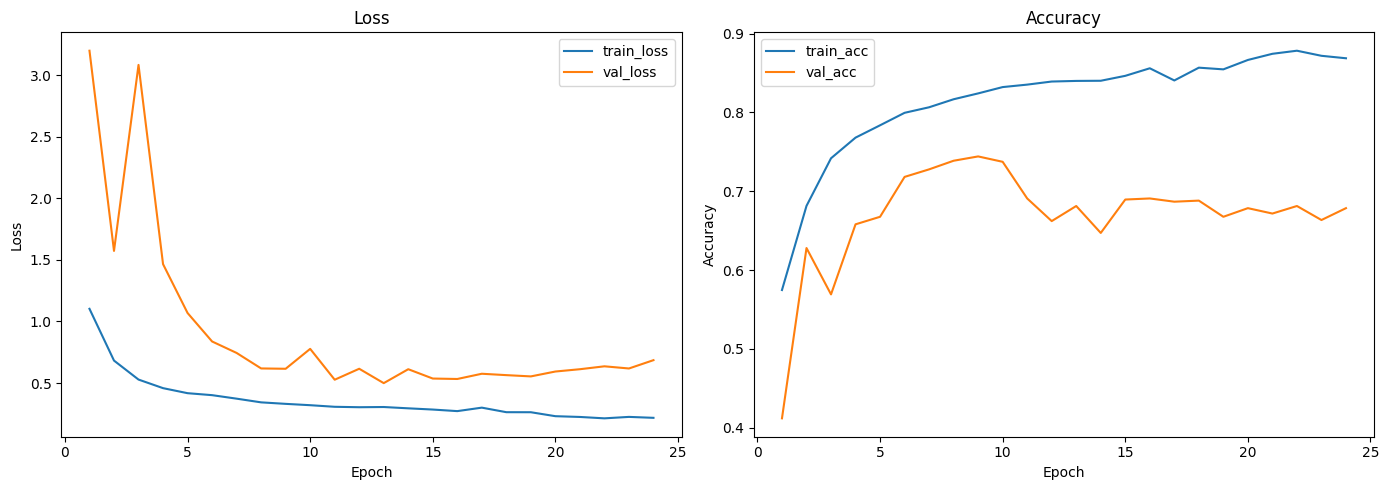

In [16]:
# Plot training curves
# -------------------------
def plot_training(history):
    hist = history.history
    epochs_r = range(1, len(hist['loss'])+1)
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_r, hist['loss'], label='train_loss')
    plt.plot(epochs_r, hist['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend();
    plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(epochs_r, hist['accuracy'], label='train_acc')
    plt.plot(epochs_r, hist['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend();
    plt.title('Accuracy')
    plt.tight_layout()
    plt.savefig("training_curves.png", dpi=150)
    plt.show()

plot_training(history)

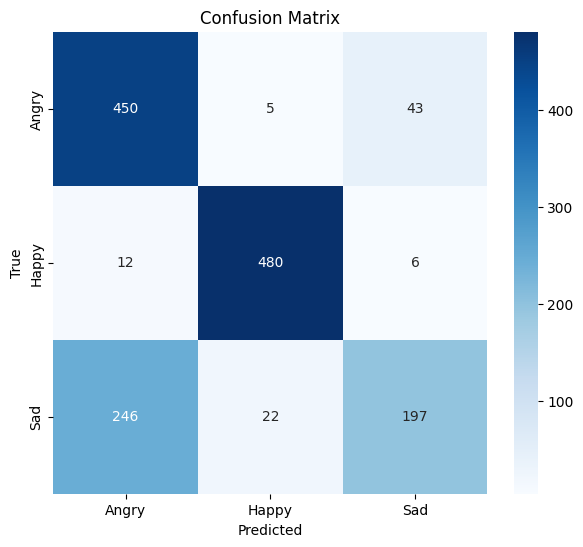

In [17]:
# Confusion matrix visualization
# -------------------------
cm = confusion_matrix(y_true_idx, y_pred_idx)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png", dpi=150)
plt.show()


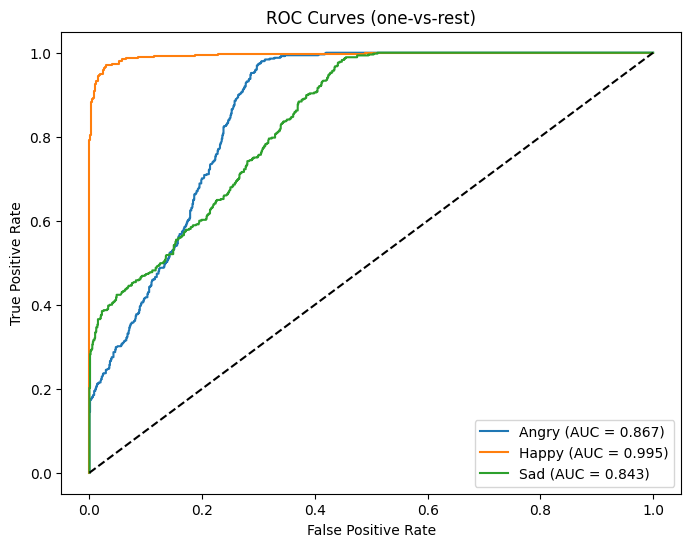

In [18]:
# ROC curves per class (one-vs-rest)
# -------------------------
plt.figure(figsize=(8,6))
for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves (one-vs-rest)')
plt.legend(loc='lower right')
plt.savefig("roc_curves.png", dpi=150)
plt.show()

46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 395ms/step
Running t-SNE (this may take a while)...


c:\Users\MAXQUANTA-INDUSTRIES\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\MAXQUANTA-INDUSTRIES\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "c:\Users\MAXQUANTA-INDUSTRIES\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
  File "c:\Users\MAXQUANTA-INDUSTRIES\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with P

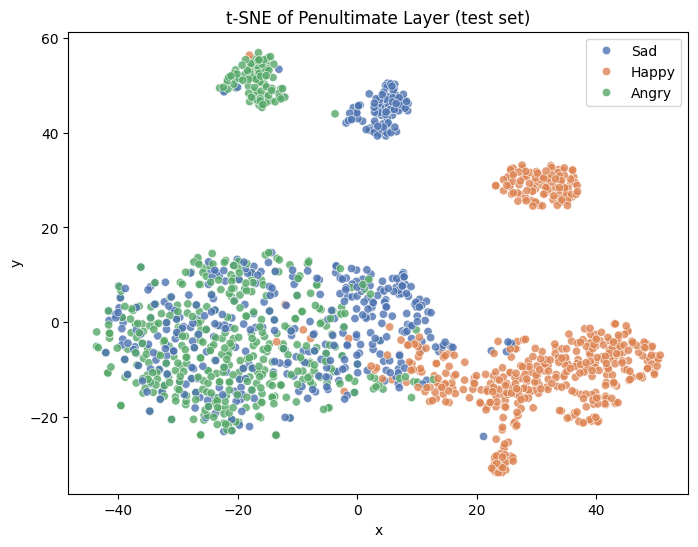

Saved classification_report.csv, confusion_matrix.png, roc_curves.png, tsne.png, training_curves.png


In [20]:
# t-SNE visualization from penultimate layer features
# -------------------------
# Create an intermediate model that outputs the penultimate dense layer prior to softmax
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)  # adjust index if model architecture different

# Build dataset of all test images (no batching complications)
def dataset_to_numpy(ds):
    imgs = []
    lbls = []
    for batch_imgs, batch_lbls in ds:
        imgs.append(batch_imgs.numpy())
        lbls.append(batch_lbls.numpy())
    imgs = np.vstack(imgs)
    lbls = np.vstack(lbls)
    return imgs, lbls

test_imgs_np, test_lbls_np = dataset_to_numpy(test_ds)
features = feature_extractor.predict(test_imgs_np, verbose=1)

print("Running t-SNE (this may take a while)...")
from sklearn import __version__ as skl_version

# default n_iter is 1000 in most sklearn versions
if tuple(map(int, skl_version.split(".")[:2])) >= (1, 5):
    tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)  # no n_iter param
else:
    tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)

features_2d = tsne.fit_transform(features)

df_tsne = pd.DataFrame({
    'x': features_2d[:,0],
    'y': features_2d[:,1],
    'label': [class_names[idx] for idx in np.argmax(test_lbls_np, axis=1)]
})
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_tsne, x='x', y='y', hue='label', palette='deep', alpha=0.8)
plt.title('t-SNE of Penultimate Layer (test set)')
plt.legend()
plt.savefig("tsne.png", dpi=150)
plt.show()

# -------------------------
# Save evaluation results (classification metrics) to CSV for record
# -------------------------
df_report = pd.DataFrame(report).transpose()
df_report.to_csv("classification_report.csv", index=True)
print("Saved classification_report.csv, confusion_matrix.png, roc_curves.png, tsne.png, training_curves.png")

# -------------------------
# Utility predict function (for Streamlit use)
# -------------------------
def preprocess_face_for_model(face_image_array):
    """
    Accepts a face crop as numpy array (RGB) — resizes to IMG_SIZE, scales to 0-1 and returns batched.
    """
    img = tf.image.resize(face_image_array, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return np.expand_dims(img.numpy(), axis=0) if isinstance(img, tf.Tensor) else np.expand_dims(img, axis=0)

def predict_emotion_from_face(model, face_rgb_array):
    """
    face_rgb_array: numpy array HxWx3 (RGB)
    returns: predicted label, confidence, probs
    """
    x = tf.image.resize(face_rgb_array, IMG_SIZE)
    x = tf.cast(x, tf.float32) / 255.0
    preds = model.predict(np.expand_dims(x.numpy(), axis=0))
    idx = np.argmax(preds[0])
    return class_names[idx], float(preds[0][idx]), preds[0]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight

# ---------------------------
# CONFIG
# ---------------------------
MODEL_PATH = "emotion_mobilenetv2.keras"  # your saved model
DATASET_DIR = r"C:/Users/MAXQUANTA-INDUSTRIES/Desktop/3 Emotion Traning Model/dataset"  # contains Angry/, Happy/, Sad/
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20  # fine-tuning only

# ---------------------------
# LOAD MODEL
# ---------------------------
model = load_model(MODEL_PATH)
print(f"Loaded model from {MODEL_PATH}")

# ---------------------------
# UNFREEZE MORE LAYERS
# ---------------------------
fine_tune_from = 50
for layer in model.layers[fine_tune_from:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ---------------------------
# DATA AUGMENTATION & SPLIT
# ---------------------------
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% val
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# ---------------------------
# CLASS WEIGHTS
# ---------------------------
labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# ---------------------------
# TRAIN
# ---------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights
)

# ---------------------------
# SAVE UPDATED MODEL
# ---------------------------
model.save("emotion_mobilenetv2_finetuned.keras")
print("Fine-tuned model saved as emotion_mobilenetv2_finetuned.keras")


Loaded model from emotion_mobilenetv2.keras
Found 5846 images belonging to 3 classes.
Found 1459 images belonging to 3 classes.
Class Weights: {0: np.float64(0.9782463186077643), 1: np.float64(0.9787376527708019), 2: np.float64(1.0459831812488818)}


c:\Users\MAXQUANTA-INDUSTRIES\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - accuracy: 0.7462 - loss: 0.5343 - val_accuracy: 0.8328 - val_loss: 0.4393
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.7615 - loss: 0.4855 - val_accuracy: 0.8376 - val_loss: 0.3905
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.7668 - loss: 0.4668 - val_accuracy: 0.8424 - val_loss: 0.3766
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.7530 - loss: 0.4610 - val_accuracy: 0.8540 - val_loss: 0.3423
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.7614 - loss: 0.4597 - val_accuracy: 0.8533 - val_loss: 0.3477
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.7672 - loss: 0.4384 - val_accuracy: 0.8554 - val_loss: 0.3372
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.7648 - loss: 0.4485 - val_accuracy: 0.8574 - val_loss: 0.3416
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.7607 - loss: 0.4343 - val_accu

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

# -----------------------------
# CONFIG
# -----------------------------
MODEL_PATH = "emotion_mobilenetv2_finetuned.keras"  # your saved model
DATASET_DIR = r"C:/Users/MAXQUANTA-INDUSTRIES/Desktop/3 Emotion Traning Model/dataset"  # contains Angry/, Happy/, Sad/
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20  # fine-tuning epochs
NEW_MODEL_PATH = "model_final_balanced.keras"

# -----------------------------
# LOAD PREVIOUS MODEL
# -----------------------------
model = load_model(MODEL_PATH)
print("✅ Model loaded from:", MODEL_PATH)

# -----------------------------
# DATA AUGMENTATION
# -----------------------------
# Base augmentation for all classes
base_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # use 20% for validation
)

# Train generator
train_gen = base_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

# Validation generator
val_gen = base_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

# -----------------------------
# CLASS WEIGHTS (boost Angry importance)
# -----------------------------
labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert to dict
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

# Boost Angry weight even more
angry_index = list(train_gen.class_indices.keys()).index("Angry")
class_weights_dict[angry_index] *= 1.5

print("📊 Class Weights:", class_weights_dict)

# -----------------------------
# FINE-TUNE MODEL
# -----------------------------
# Lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights_dict
)

# -----------------------------
# SAVE NEW MODEL
# -----------------------------
model.save(NEW_MODEL_PATH)
print("✅ Improved model saved as:", NEW_MODEL_PATH)


✅ Model loaded from: emotion_mobilenetv2_finetuned.keras
Found 5846 images belonging to 3 classes.
Found 1459 images belonging to 3 classes.
📊 Class Weights: {0: np.float64(1.4673694779116464), 1: np.float64(0.9787376527708019), 2: np.float64(1.0459831812488818)}


c:\Users\MAXQUANTA-INDUSTRIES\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.8000 - loss: 0.4495 - val_accuracy: 0.8855 - val_loss: 0.2811
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.8041 - loss: 0.4332 - val_accuracy: 0.8766 - val_loss: 0.2795
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.8076 - loss: 0.4283 - val_accuracy: 0.8773 - val_loss: 0.2808
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.8059 - loss: 0.4261 - val_accuracy: 0.8821 - val_loss: 0.2834
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.8091 - loss: 0.4263 - val_accuracy: 0.8814 - val_loss: 0.2673
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.8064 - loss: 0.4243 - val_accuracy: 0.8821 - val_loss: 0.2714
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.8070 - loss: 0.4267 - val_accuracy: 0.8711 - val_loss: 0.3036
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.8098 - loss: 0.4254 - val_accu

✅ Model loaded from: model_final_balanced.keras
Found 1459 images belonging to 3 classes.


c:\Users\MAXQUANTA-INDUSTRIES\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 430ms/step

📋 Classification Report:
              precision    recall  f1-score   support

       Angry       0.83      0.83      0.83       497
       Happy       0.97      0.96      0.97       497
         Sad       0.81      0.82      0.81       465

    accuracy                           0.87      1459
   macro avg       0.87      0.87      0.87      1459
weighted avg       0.87      0.87      0.87      1459



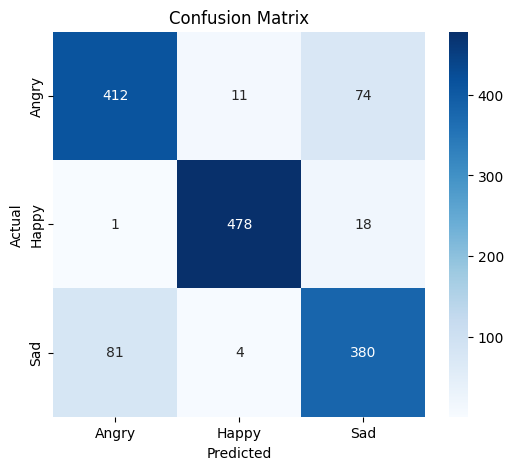

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
MODEL_PATH = "model_final_balanced.keras"  # your fine-tuned Angry model
DATA_DIR = "dataset"  # folder with Angry, Happy, Sad subfolders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# -----------------------------
# LOAD MODEL
# -----------------------------
model = load_model(MODEL_PATH)
print("✅ Model loaded from:", MODEL_PATH)

# -----------------------------
# VALIDATION GENERATOR
# -----------------------------
datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# -----------------------------
# PREDICTION
# -----------------------------
val_gen.reset()
pred_probs = model.predict(val_gen)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# -----------------------------
# CLASSIFICATION REPORT
# -----------------------------
print("/n📋 Classification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# -----------------------------
# CONFUSION MATRIX
# -----------------------------
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Found 7305 images belonging to 3 classes.


c:\Users\MAXQUANTA-INDUSTRIES\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


229/229 ━━━━━━━━━━━━━━━━━━━━ 94s 404ms/step
              precision    recall  f1-score   support

       Angry       0.70      0.91      0.79      2489
       Happy       0.99      0.99      0.99      2488
         Sad       0.86      0.59      0.70      2328

    accuracy                           0.83      7305
   macro avg       0.85      0.83      0.83      7305
weighted avg       0.85      0.83      0.83      7305



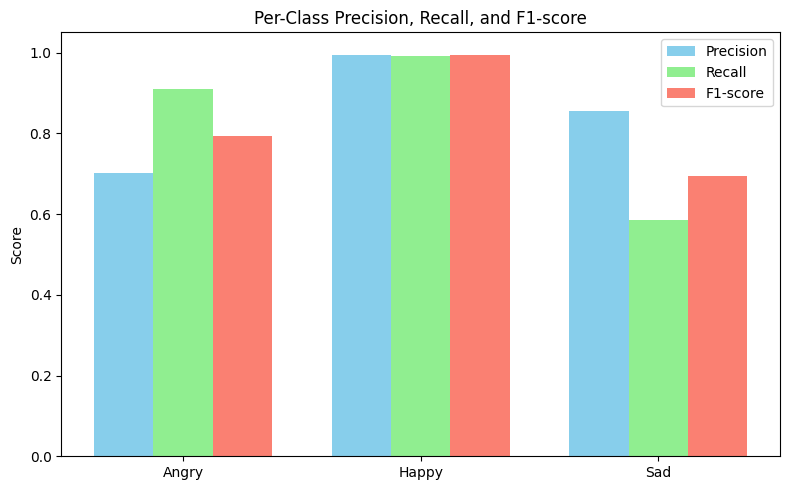

C:\Users\MAXQUANTA-INDUSTRIES\AppData\Local\Temp\ipykernel_3524\1208049383.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=support, palette='viridis')


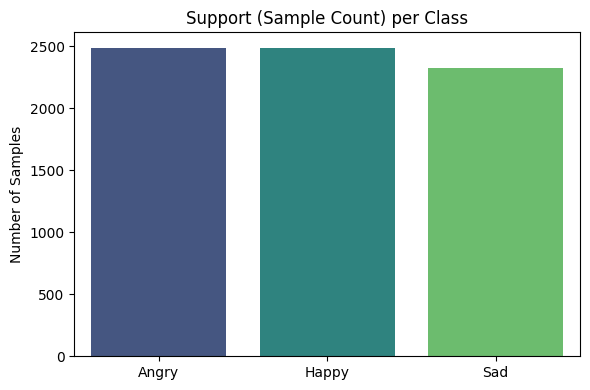

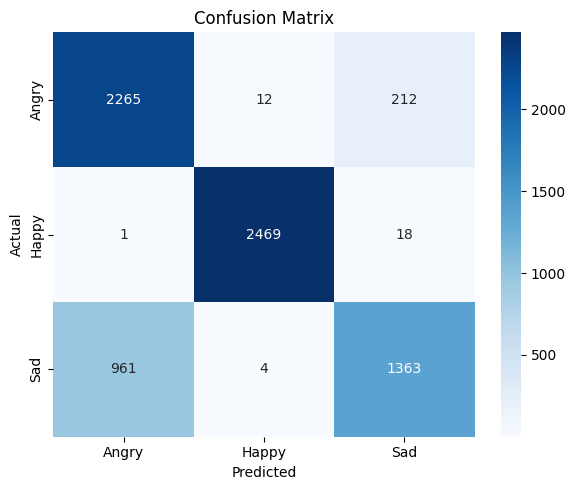

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ====== USER PATHS ======
model_path = r"C:\Users\MAXQUANTA-INDUSTRIES\Desktop\3 Emotion Traning Model\final_model_train\model_final_balanced.keras"
data_dir = "dataset"  # Folder with subfolders Angry, Happy, Sad

# ====== LOAD MODEL ======
model = load_model(model_path)

# ====== LOAD TEST DATA ======
img_size = (224, 224)
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# ====== PREDICTIONS ======
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# ====== CLASSIFICATION REPORT ======
report_dict = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
report_text = classification_report(y_true, y_pred, target_names=class_labels)
print(report_text)

# ====== PER-CLASS PRECISION, RECALL, F1 ======
precision = [report_dict[cls]["precision"] for cls in class_labels]
recall = [report_dict[cls]["recall"] for cls in class_labels]
f1 = [report_dict[cls]["f1-score"] for cls in class_labels]
support = [report_dict[cls]["support"] for cls in class_labels]

x = np.arange(len(class_labels))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, precision, width, label='Precision', color='skyblue')
plt.bar(x, recall, width, label='Recall', color='lightgreen')
plt.bar(x + width, f1, width, label='F1-score', color='salmon')
plt.xticks(x, class_labels)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Per-Class Precision, Recall, and F1-score")
plt.legend()
plt.tight_layout()
plt.show()

# ====== SUPPORT DISTRIBUTION ======
plt.figure(figsize=(6, 4))
sns.barplot(x=class_labels, y=support, palette='viridis')
plt.ylabel("Number of Samples")
plt.title("Support (Sample Count) per Class")
plt.tight_layout()
plt.show()

# ====== CONFUSION MATRIX ======
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
